Load Dataset and List Unique Values
Load the Dataset: Load the raw dataset from the data/raw directory.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

file_path = '../data/raw/Air_Quality_20240801.csv'
data = pd.read_csv(file_path)


List Unique Values in 'Name' Column: Identify the unique indicators in the dataset.

In [2]:
unique_names = data['Name'].unique()
print(unique_names)

['Boiler Emissions- Total SO2 Emissions' 'Fine particles (PM 2.5)'
 'Nitrogen dioxide (NO2)'
 'Asthma emergency department visits due to PM2.5'
 'Annual vehicle miles traveled'
 'Respiratory hospitalizations due to PM2.5 (age 20+)' 'Ozone (O3)'
 'Asthma hospitalizations due to Ozone'
 'Boiler Emissions- Total NOx Emissions'
 'Boiler Emissions- Total PM2.5 Emissions'
 'Outdoor Air Toxics - Formaldehyde'
 'Asthma emergency departments visits due to Ozone'
 'Cardiovascular hospitalizations due to PM2.5 (age 40+)'
 'Cardiac and respiratory deaths due to Ozone' 'Deaths due to PM2.5'
 'Outdoor Air Toxics - Benzene' 'Annual vehicle miles traveled (trucks)'
 'Annual vehicle miles traveled (cars)']


Calculate Descriptive Statistics for PM 2.5. 
Filter PM 2.5 Data: Focus on the 'Fine particles (PM 2.5)' indicator.

In [3]:
pm25_data = data[data['Name'] == 'Fine particles (PM 2.5)']

Calculate Statistics: Compute mean, median, and standard deviation for PM 2.5 across neighborhoods.

In [4]:
pm25_stats = pm25_data.groupby('Geo Place Name')['Data Value'].agg(['mean', 'median', 'std']).reset_index()
pm25_stats

,Geo Place Name,mean,median,std
0,Bay Ridge and Dyker Heights (CD10),8.638095,8.45,1.756653
1,Bayside - Little Neck,8.323810,8.05,1.667452
2,Bayside Little Neck-Fresh Meadows,8.345238,8.05,1.702395
3,Bayside and Little Neck (CD11),8.309524,8.05,1.668914
4,Bedford Stuyvesant (CD3),9.057143,8.95,1.819561
...,...,...,...,...
109,West Queens,9.292857,9.10,1.759572
110,Williamsbridge and Baychester (CD12),8.852381,8.65,1.918109
111,Williamsburg - Bushwick,9.767857,9.50,2.037490
112,Willowbrook,8.340476,8.10,1.851309


Identify Outliers in PM 2.5 Measurements. Identify Outliers Function: Define a function to detect outliers.

In [5]:
def identify_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]


Apply Outlier Detection: Detect outliers in PM 2.5 data.

In [6]:
pm25_outliers = pm25_data.groupby('Geo Place Name')['Data Value'].apply(identify_outliers).reset_index()
pm25_outliers


,Geo Place Name,level_1,Data Value
0,East New York,5589,13.5
1,Kingsbridge - Riverdale,16331,14.7
2,Kingsbridge - Riverdale,17144,14.7
3,Riverdale and Fieldston (CD8),10266,14.7
4,Williamsburg - Bushwick,16179,15.1


Plot SO2 Emissions Distribution for Top 10 Neighborhoods

In [7]:
so2_data = data[data['Name'] == 'Boiler Emissions- Total SO2 Emissions']
top10_neighborhoods = so2_data.groupby('Geo Place Name')['Data Value'].mean().nlargest(10).index
so2_top10 = so2_data[so2_data['Geo Place Name'].isin(top10_neighborhoods)]


Plot Distribution: Visualize the distribution of SO2 emissions.

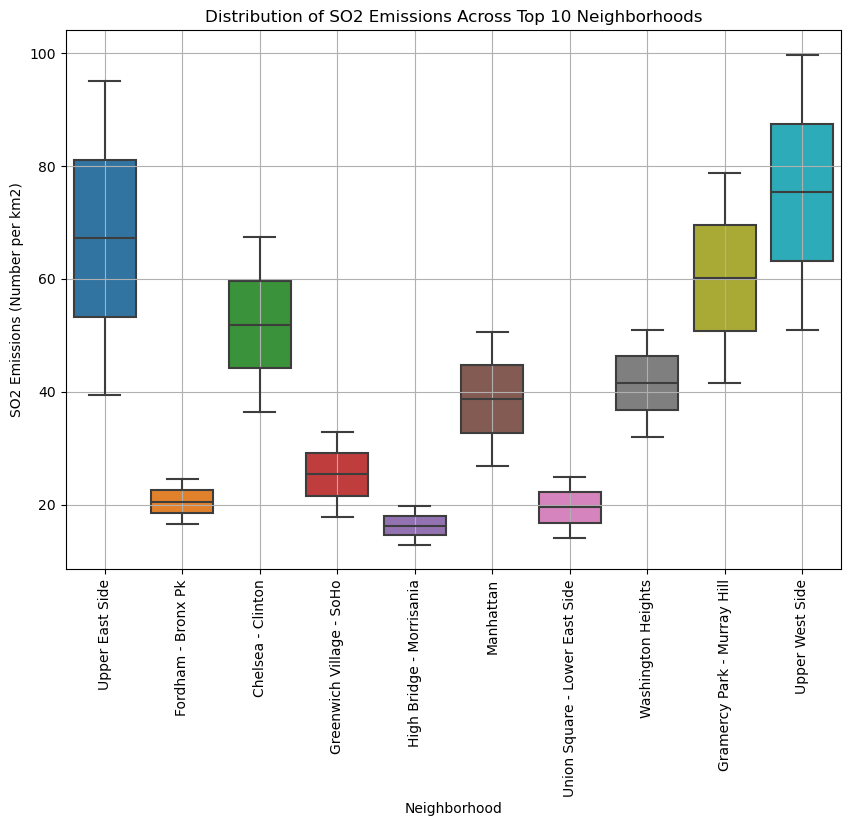

In [8]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Geo Place Name', y='Data Value', data=so2_top10)
plt.title('Distribution of SO2 Emissions Across Top 10 Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('SO2 Emissions (Number per km2)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


Define Analysis Function for Specific Questions. 
Analysis Function: Create a function to analyze specific indicators

In [17]:
def analyze_indicator(asthma_indicator, pollution_indicator):
    asthma_visits = data[data['Name'] == asthma_indicator].copy()
    pollution_data = data[data['Name'] == pollution_indicator].copy()

    asthma_visits['Start_Date'] = pd.to_datetime(asthma_visits['Start_Date'], errors='coerce')
    pollution_data['Start_Date'] = pd.to_datetime(pollution_data['Start_Date'], errors='coerce')

    asthma_visits = asthma_visits.dropna(subset=['Start_Date'])
    pollution_data = pollution_data.dropna(subset=['Start_Date'])

    asthma_visits['Year'] = asthma_visits['Start_Date'].dt.year.astype(int)
    pollution_data['Year'] = pollution_data['Start_Date'].dt.year.astype(int)

    annual_pollution = pollution_data.groupby('Year')['Data Value'].mean().reset_index()
    annual_asthma = asthma_visits.groupby('Year')['Data Value'].sum().reset_index()

    annual_pollution['Data Value'].replace([np.inf, -np.inf], np.nan, inplace=True)
    annual_asthma['Data Value'].replace([np.inf, -np.inf], np.nan, inplace=True)

    annual_pollution.dropna(subset=['Data Value'], inplace=True)
    annual_asthma.dropna(subset=['Data Value'], inplace=True)

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Year', y='Data Value', data=annual_pollution, marker='o')
    plt.title(f'Annual Mean {pollution_indicator} Levels')
    plt.xlabel('Year')
    plt.ylabel(f'{pollution_indicator} Levels (units)')
    plt.grid(True)
    plt.xticks(annual_pollution['Year'])
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Year', y='Data Value', data=annual_asthma, marker='o')
    plt.title(f'Annual {asthma_indicator}')
    plt.xlabel('Year')
    plt.ylabel('Number of Visits')
    plt.grid(True)
    plt.xticks(annual_asthma['Year'])
    plt.show()

    # Save the processed data for local storage
    annual_pollution.to_csv(f'../data/processed/Annual_{pollution_indicator.replace(" ", "_").replace("(", "").replace(")", "")}.csv', index=False)
    annual_asthma.to_csv(f'../data/processed/Annual_{asthma_indicator.replace(" ", "_").replace("(", "").replace(")", "")}.csv', index=False)

    merged_data = pd.merge(annual_asthma, annual_pollution, on='Year', suffixes=('_asthma', f'_{pollution_indicator.replace(" ", "_").replace("(", "").replace(")", "")}'))

    if len(merged_data) >= 2:
        correlation, p_value = pearsonr(merged_data['Data Value_asthma'], merged_data[f'Data Value_{pollution_indicator.replace(" ", "_").replace("(", "").replace(")", "")}'])
        print(f"Correlation coefficient between {asthma_indicator} and {pollution_indicator}: {correlation}")
        print(f"P-value: {p_value}")
    else:
        print(f"Not enough data points for correlation analysis between {asthma_indicator} and {pollution_indicator}")



Analyze Specific Questions. Analyze Specific Questions: Use the analysis function for the specified indicators

c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


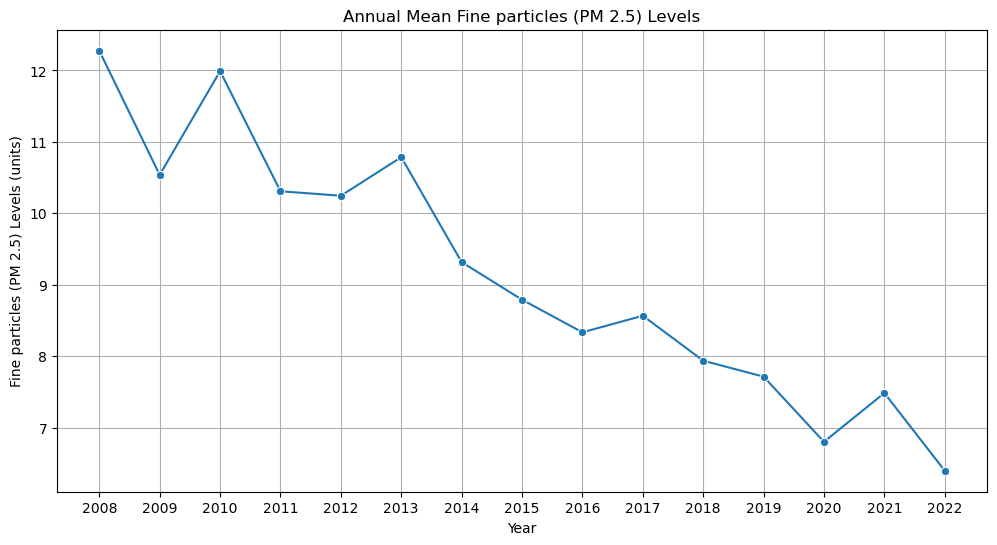

c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


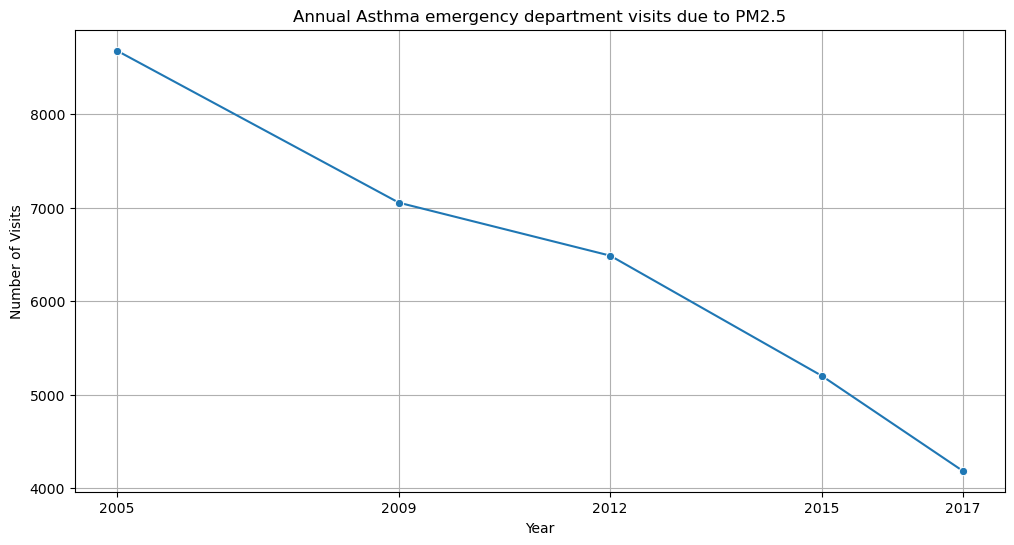

c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Correlation coefficient between Asthma emergency department visits due to PM2.5 and Fine particles (PM 2.5): 0.9699081793005258
P-value: 0.030091820699474248


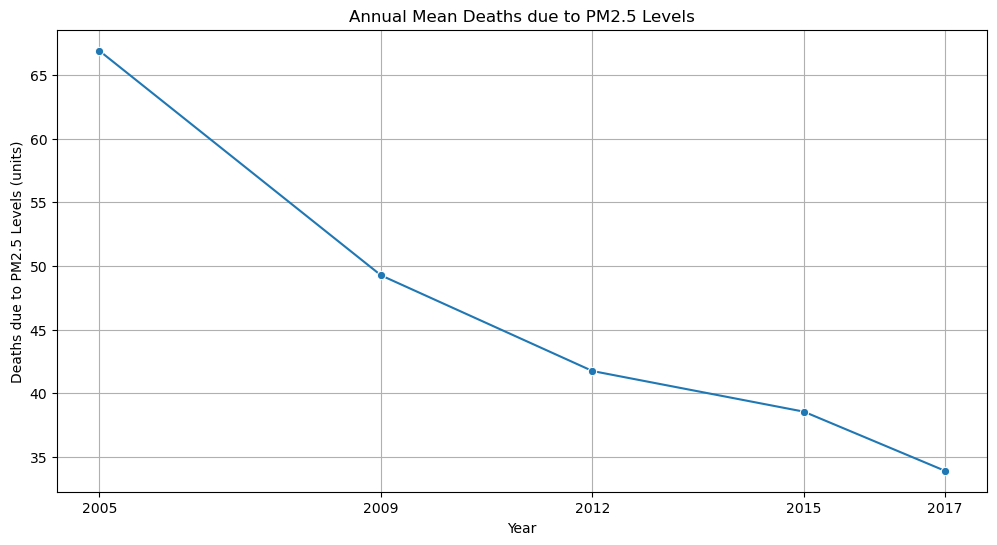

c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


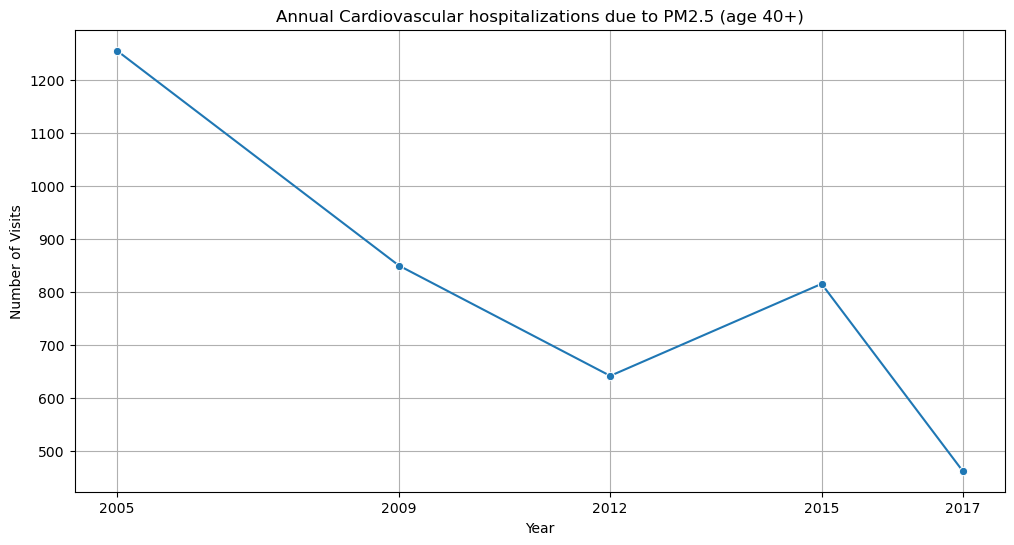

c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Correlation coefficient between Cardiovascular hospitalizations due to PM2.5 (age 40+) and Deaths due to PM2.5: 0.9384064144519191
P-value: 0.018179562589573987


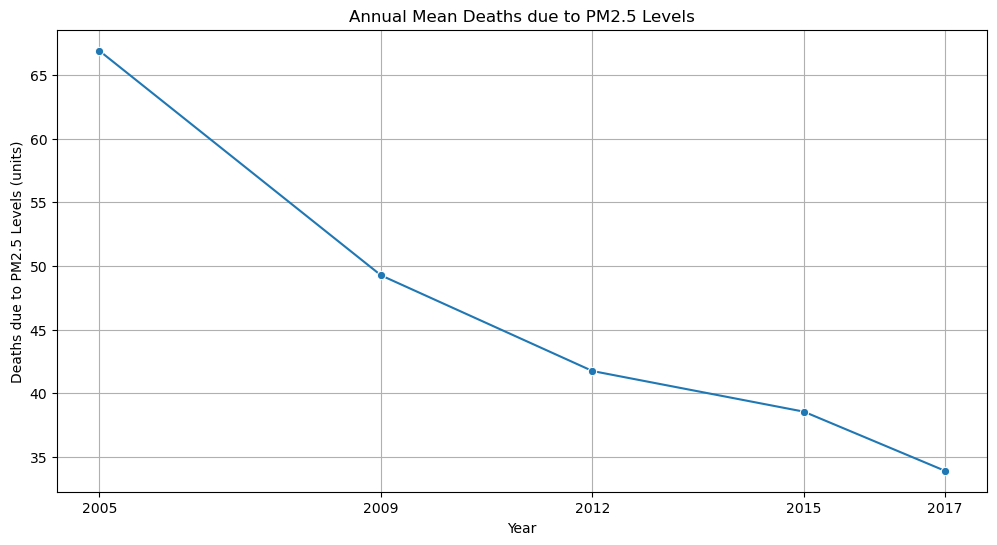

c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\melkabas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


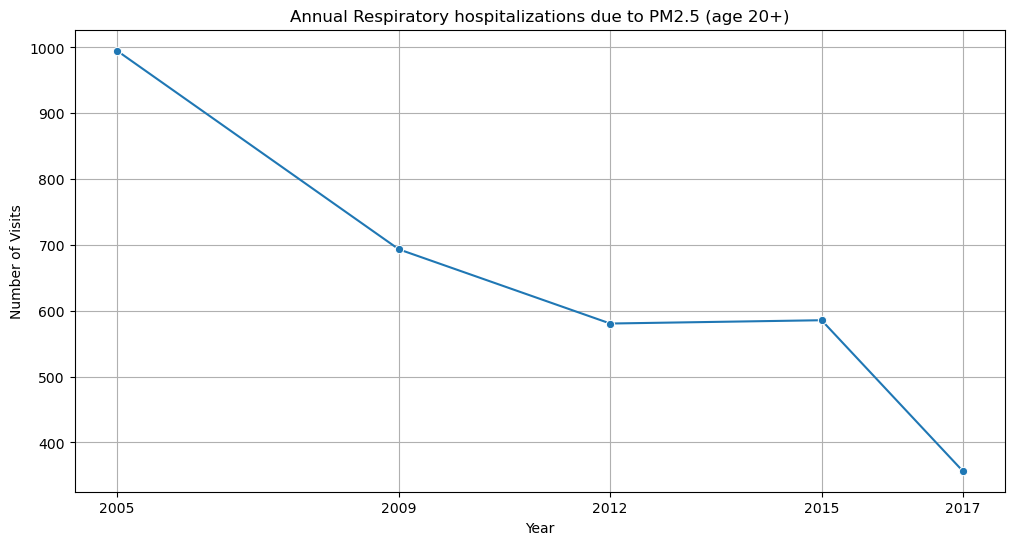

Correlation coefficient between Respiratory hospitalizations due to PM2.5 (age 20+) and Deaths due to PM2.5: 0.9735919140436167
P-value: 0.005131110909126834


In [22]:
# Question 1: How do asthma emergency department visits correlate with Fine particles in different neighborhoods?
analyze_indicator('Asthma emergency department visits due to PM2.5', 'Fine particles (PM 2.5)')

# Question 2: What is the relationship between Deaths due to PM2.5 and cardiovascular hospitalizations (age 40+) across NYC?
analyze_indicator('Cardiovascular hospitalizations due to PM2.5 (age 40+)', 'Deaths due to PM2.5')

# Question 3: Analyze the correlation between respiratory hospitalizations (age 20+) and Deaths due to PM 2.5.
analyze_indicator('Respiratory hospitalizations due to PM2.5 (age 20+)', 'Deaths due to PM2.5')


Summary of Results

Asthma Emergency Department Visits and Fine Particles (PM 2.5):
Correlation Coefficient: 0.9699
P-value: 0.0301
Interpretation: Strong positive correlation, statistically significant. Higher PM 2.5 levels are strongly associated with more asthma emergency visits.

Cardiovascular Hospitalizations (age 40+) and Deaths due to PM 2.5:
Correlation Coefficient: 0.9384
P-value: 0.0182
Interpretation: Strong positive correlation, statistically significant. Higher cardiovascular hospitalizations are strongly associated with more deaths due to PM 2.5.

Respiratory Hospitalizations (age 20+) and Fine Particles (PM 2.5):
Correlation Coefficient: 0.9736
P-value: 0.0051
Interpretation: Very strong positive correlation, statistically significant. Higher respiratory hospitalizations due to PM2.5 are strongly associated with more deaths due to PM 2.5.